# CPSC 330 - Applied Machine Learning 

## Homework 7: Clustering and recommender systems
### Associated lectures: Lectures 14 and 15

**Due date: ~~Monday, November 15, 2021~~ Wednesday, November 17, 11:59pm**

> Note that this homework is much shorter and simpler than the usual homework assignments because homework 6 is also due on November 15th. 

In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

pd.set_option("display.max_colwidth", 0)

<br><br><br><br>

## Instructions 
<hr>
rubric={points:2}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330/blob/master/docs/homework_instructions.md). 

**You may work on this homework in a group and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 3. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

<br><br><br><br>

## Exercise 1: Document clustering toy example <a name="1"></a>
<hr>

In lecture 14, we looked at a popular application of clustering: customer segmentation. In this homework, we will work on a toy example of another popular application: [**document clustering**](https://en.wikipedia.org/wiki/Document_clustering). A large amount of unlabeled text data is available out there (e.g., news, recipes, online Q&A), and clustering is a commonly used technique to organize this data in a meaningful way. 

In this exercise, we will create a toy dataset with sentences from Wikipedia articles and cluster these sentences. 

### 1.1 Sample sentences from Wikipedia articles
rubric={points:2}

The code below extracts first sentences of Wikipedia articles on a set of queries. You will need the `wikipedia` package installed in the course environment to run the code below. 

```
conda activate cpsc330
conda install -c conda-forge wikipedia
```

You also need `nltk` library in the course environment. 

```
conda install -c anaconda nltk 
```        

**Your tasks:**

Run the code below and answer the following question. 

1. Given this dataset, how many clusters would you expect a clustering algorithm to identify? How would you manually label these clusters?   

> *Note 2: Feel free to experiment with queries of your choice. But stick to the provided list for the final submission so that it's easier for the TAs when they grade your submission.*


In [2]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download("punkt")

[nltk_data] Downloading package punkt to /Users/jpan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
import wikipedia

queries = [
    "mango_fruit",
    "pastry",
    "Julia language",
    "Python language",
    "hockey",
    "football",
    "supervised learning",
    "unsupervised learning"    
]

wiki_dict = {"wiki query": [], "text": [], "n_words": []}
for i in range(len(queries)):
    sent = sent_tokenize(wikipedia.page(queries[i]).content)[0]
    wiki_dict["text"].append(sent)
    wiki_dict["n_words"].append(len(word_tokenize(sent)))
    wiki_dict["wiki query"].append(queries[i])

wiki_df = pd.DataFrame(wiki_dict)
wiki_df

,wiki query,text,n_words
0,mango_fruit,"A mango is an edible stone fruit produced by the tropical tree Mangifera indica which is believed to have originated from the region between northwestern Myanmar, Bangladesh, and northeastern India.",33
1,pastry,"Pastry is a dough of flour, water and shortening (solid fats, including butter or lard) that may be savoury or sweetened.",26
2,Julia language,"Julia is a high-level, high-performance, dynamic programming language.",11
3,Python language,Python is an interpreted high-level general-purpose programming language.,9
4,hockey,Hockey is a sport in which two teams play against each other by trying to manoeuvre a ball or a puck into the opponent's goal using a hockey stick.,31
5,football,"Football is a family of team sports that involve, to varying degrees, kicking a ball to score a goal.",22
6,supervised learning,Supervised learning (SL) is the machine learning task of learning a function that maps an input to an output based on example input-output pairs.,27
7,unsupervised learning,Unsupervised learning is a type of machine learning in which the algorithm is not provided with any pre-assigned labels or scores for the training data.,26


We would expect there to be 4 clusters with the following queries grouped:
- `mango_fruit` and `pastry`
- `Julia language` and `Python language`
- `hockey` and `football`
- `supervised learning` and `unsupervised learning`

To manually label these queries, we would look at the similarity between a query and every other query. Specifically, we would count up the number of common words between the text in one query and that of another query. Queries grouped together would have the maximum number of similar words. Queries in different groups would have minimal common words.

Since the wiki queries can be intuitively clustered by a human without complex analysis, if we were to manually assign labels, we would assign the following to the clusters.
- "food" - `mango_fruit` and `pastry`
- "programming languages" - `Julia language` and `Python language`
- "sports" - `hockey` and `football`
- "machine learning" - `supervised learning` and `unsupervised learning`

<!-- This is b/c the dataset is formed by 8 unique queries that are relatively different in subject matter. To manually label these clusters, one can compare the original wiki queries with their respective texts. -->

<br><br>

### 1.2 `KMeans` with bag-of-words representation 
rubric={points:4}

We have seen that before we pass text to machine learning models, we need to encode it into a numeric representation. So let's encode our toy dataset above (`wiki_df`) to a numeric representation. 

First, let's try our good old friend: bag-of-words representation. The code below creates dense bag-of-words representation of Wikipedia sentences from 1.1 with [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). 

**Your tasks:**

Run the code below and answer the following questions. 

1. Run `KMeans` clustering on the transformed data (`bow_sents`) with K = the number of clusters you identified in 1.1.  
2. Examine clustering labels assigned by `KMeans`. Is `KMeans` doing a reasonable job in clustering the sentences? 

> You can access cluster label assignments using `labels_` attribute of the clustering object. 

In [4]:
vec = CountVectorizer(stop_words='english')
bow_sents = vec.fit_transform(wiki_df["text"]).todense()
bow_df = pd.DataFrame(
    data=bow_sents, columns=vec.get_feature_names(), index=wiki_df.index
)
bow_df

/Users/jpan/miniconda3/envs/cpsc330/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,algorithm,assigned,ball,bangladesh,based,believed,butter,data,degrees,dough,...,teams,training,tree,tropical,trying,type,unsupervised,using,varying,water
0,0,0,0,1,0,1,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
5,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
6,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,1,0,0,0


In [5]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(bow_sents)
kmeans_bow_labels = kmeans.labels_
kmeans_bow_labels

/Users/jpan/miniconda3/envs/cpsc330/lib/python3.9/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


array([3, 1, 1, 1, 0, 1, 2, 2], dtype=int32)

The cluster labels assigned are inconsistent (i.e. the assignments change with every execution). For example:
- sometimes, `supervised learning` and `unsupervised learning` are assigned the same cluster, but other times, they are assigned to different clusters.
- `mango fruit` usually gets assigned to its own cluster, but `pastry` is assigned with `Julia language` and `Python language` most of the time, which does not make much sense.
- `hockey` and `football` are usually assigned to the same cluster as the programming languages.

Overall, `kMeans` is not doing a great job clustering the sentences with bag-of-words representation.

<br><br>

### 1.3 Sentence embedding representation
rubric={points:6}

Clustering is sensitive to what kind of representation we use for the given data. 
Bag-of-words representation is limited in that it does not take into account word ordering and context. There are other richer representations of text, and we are going to use one such representation in this exercise. 

The code below creates an alternative and a more expressive representation of sentences. We will call it *sentence embedding representation*. We'll use [sentence transformer](https://www.sbert.net/index.html) to extract these representations. At this point it's enough to know that this is an alternative representation of text which usually works better than simple bag-of-words representation. We will talk a bit more about embedding representations next week. You need to install `sentence-transformers` in the course conda environment to run the code below. 

```
conda activate cpsc330
conda install -c conda-forge sentence-transformers
```

**Your tasks:**

Run the code below and answer the following questions. 

1. How many dimensions (features associated with each example) are present in this representation? 
2. Run `KMeans` clustering with sentence embedding representation of text (`emb_sents`) and examine cluster labels. 
3. How well the sentences are clustered together? 

In [6]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer("paraphrase-distilroberta-base-v1")

In [7]:
emb_sents = embedder.encode(wiki_df["text"])
emb_sent_df = pd.DataFrame(emb_sents, index=wiki_df.index)
emb_sent_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.056666,-0.025778,0.248909,-0.052198,-0.046876,0.202116,0.235076,0.322160,-0.023798,0.133034,...,0.239581,-0.022871,0.071445,0.402666,-0.134781,0.177697,-0.123651,0.446758,0.204768,-0.048541
1,-0.062657,0.214340,-0.025160,0.276730,0.401149,0.030865,-0.089944,0.331922,-0.247056,0.175028,...,0.039294,-0.100197,0.201217,0.257111,0.194594,0.280075,0.037366,0.205146,0.044872,-0.078719
2,0.063674,0.287057,0.098705,0.048766,0.562877,-0.015978,-0.129418,0.098363,0.249305,0.269618,...,0.483838,-0.017337,0.194522,0.185484,0.536236,0.137246,0.368983,-0.028611,-0.017652,-0.192852
3,0.112807,-0.137214,0.082946,-0.066925,0.558055,0.197494,-0.034394,0.421297,0.105453,0.280035,...,0.464874,0.291358,-0.028042,0.120064,0.021188,0.300265,0.323036,0.072128,0.047298,-0.076177
4,-0.027003,-0.244207,-0.090704,0.037250,0.029517,-0.441170,0.205250,0.373760,-0.046666,-0.006260,...,0.479729,-0.121557,0.002595,-0.147080,-0.277788,0.082878,-0.182319,0.786005,0.235606,-0.125455
5,-0.071756,0.133157,-0.071762,0.306060,0.358961,-0.061442,0.167584,0.364614,0.323541,0.141398,...,0.404115,0.000236,0.177493,0.016162,0.232335,0.260556,0.168149,0.483963,0.121122,0.196881
6,0.056006,-0.111174,-0.041483,0.279774,0.758023,0.181266,0.128420,0.323363,0.297055,0.154679,...,-0.007967,-0.061346,0.352495,0.011700,-0.358587,-0.052314,0.370848,-0.276011,0.105793,0.175194
7,0.040102,-0.104918,-0.181901,0.099642,0.746790,0.334654,0.106366,0.238597,0.142745,0.110569,...,0.113403,0.065607,-0.014091,-0.047726,-0.410688,0.133482,0.388844,-0.313182,0.013006,-0.074868


There are **768 dimensions** since that is the number of features per example.

In [8]:
kmeans.fit(emb_sents)
kmeans_emb_labels = kmeans.labels_
kmeans_emb_labels

array([3, 3, 2, 2, 0, 0, 1, 1], dtype=int32)

The clusters are labeled much more reasonably this time, however, there are some inconsistencies upon rerunning the prediction. 
- Most of the time, food items (`pastry` and `mango_fruit`) are grouped together, programming languages (`Julia language` and `Python language`) are grouped together, sports (`hockey` and `football`) are grouped together, and machine learning techniques (`supervised learning` and `unsupervised learning`) grouped together - these clusters are reasonable.
- However, occasionally, `mango_fruit` would be grouped in the same cluster as the programming languages, which doesn't make too much sense.

Overall, `kMeans` seems to still be giving unreliable results with the sentence embedding representation.

<br><br>

### 1.4 DBSCAN with cosine distance  
rubric={points:8}

Let's try `DBSCAN` on our toy dataset. K-Means is kind of bound to the Euclidean distance because it is based on the notion of means. With `DBSCAN` we can try different distance metrics. In the context of text (sparse data), [cosine similarities](https://scikit-learn.org/stable/modules/metrics.html#cosine-similarity) or cosine distances tend to work better. Given vectors $u$ and $v$, the **cosine distance** between the vectors is defined as: 

$$distance_{cosine}(u,v) = 1 - (\frac{u \cdot v}{\left\lVert u\right\rVert_2 \left\lVert v\right\rVert_2})$$

In this exercise, you'll use DBSCAN with cosine distances. 

**Your tasks**

1. Use DBSCAN to cluster our toy data using sentence embedding representation (`emb_sents`) and `metric='cosine'`. 
2. Briefly comment on the number of clusters identified and the cluster assignment given by the algorithm.

> *Note: You will also have to set appropriate values for the hyperparamters `eps` and `min_samples` to get meaningful clusters, as default values for these hyperparameters won't work on this toy dataset. In order to set appropriate value for `eps`, you may want to examine the distances given by [sklearn's `cosine_distance`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_distances.html).*

In [9]:
from sklearn.metrics.pairwise import cosine_distances
cosine_distances(emb_sents).mean()

0.69718695

In [10]:
dbscan = DBSCAN(metric="cosine", min_samples=1, eps=0.69718695)
dbscan.fit(emb_sents)
dbscan_labels = dbscan.labels_
dbscan_labels

array([0, 1, 2, 2, 3, 3, 4, 4])

In [11]:
print("Number of clusters identified:", len(np.unique(dbscan_labels)))

Number of clusters identified: 5


There are 5 clusters identified. It appears that all pairs are grouped into their expected clusters except for the first pair where the first query result (the one for "mango_fruit") is placed in a different group from the second query result (the one for "pastry"). The first pair that forms the first cluster should have represented food items.

These results were produced with an `eps=0.69718695` as that is the mean cosine distance returned by `cosine_distances(emb_sents)`. A value of `min_samples=1` was used b/c we only need one point (any given query by itself) to represent a core point and the closest second point should be assigned to  that core point's cluster.

<br><br>

### 1.5 Visualizing clusters 
rubric={points:5}

One thing we could do with unlabeled data is visualizing it. That said, our data is high dimensional (each example is represented with 768 dimensions) and high-dimensional data is hard to visualize. One way to visualize high-dimensional data is applying dimensionality reduction to get the most important (2 or 3) components of the dataset and visualizing this low-dimensional data. 

Given data as a `numpy` array and cluster assignments, the `plot_pca_clusters` function below transforms the given data by applying dimensionality reduction and plots the transformed data into corresponding clusters. 

> *Note: At this point we are using this function only for visualization and you are not expected to understand the PCA part. Feel free to modify the function as you see fit.*

**Your tasks:**

1. Call the function `plot_pca_clusters` to visualize the clusters created by the three models above:
    - KMeans with bag-of-words representation 
    - KMeans with sentence embedding representation 
    - DBSCAN with sentence embedding representation 

In [12]:
from sklearn.decomposition import PCA # Obtain the principal components

def plot_pca_clusters(
    data,
    cluster_labels,
    raw_sents=wiki_df["text"],
    show_labels=False,
    size=100,
    title="PCA visualization",
):
    """
    Carry out dimensionality reduction using PCA and plot 2-dimensional clusters.

    Parameters
    -----------
    data : numpy array
        data as a numpy array
    cluster_labels : list
        cluster labels for each row in the dataset
    raw_sents : list
        the original raw sentences for labeling datapoints
    show_labels : boolean
        whether you want to show labels for points or not (default: False)
    size : int
        size of points in the scatterplot
    title : str
        title for the visualization plot

    Returns
    -----------
    None. Shows the clusters.
    """

    pca = PCA(n_components=2)
    principal_comp = pca.fit_transform(data)
    pca_df = pd.DataFrame(data=principal_comp, columns=["pca1", "pca2"])
    pca_df["cluster"] = cluster_labels

    plt.figure(figsize=(10, 7))
    plt.title(title)
    ax = sns.scatterplot(
        x="pca1", y="pca2", hue="cluster", data=pca_df, palette="tab10", s=size
    )

    x = pca_df["pca1"].tolist()
    y = pca_df["pca2"].tolist()
    if show_labels:
        for i, txt in enumerate(raw_sents):
            plt.annotate(" ".join(txt.split()[:10]), (x[i], y[i]))
        ax.legend(loc="upper right")

    plt.show()

/Users/jpan/miniconda3/envs/cpsc330/lib/python3.9/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


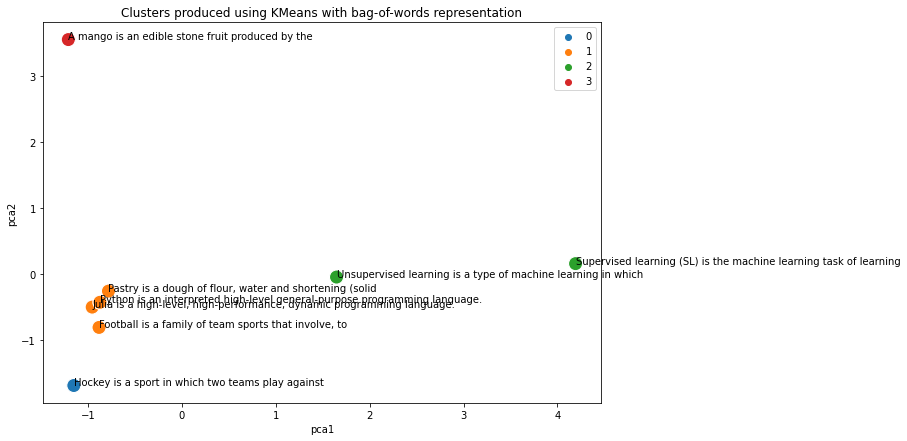

In [13]:
plot_pca_clusters(
    bow_sents,
    kmeans_bow_labels,
    wiki_df["text"],
    True,
    200,
    'Clusters produced using KMeans with bag-of-words representation'
)

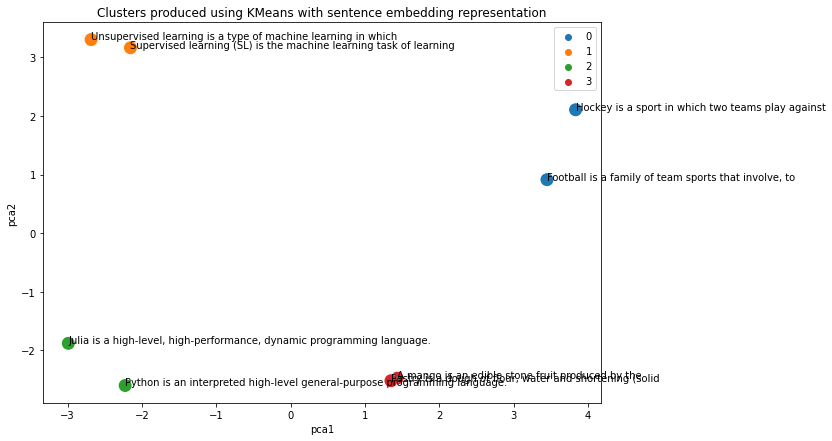

In [14]:
plot_pca_clusters(
    emb_sents,
    kmeans_emb_labels,
    wiki_df["text"],
    True,
    200,
    'Clusters produced using KMeans with sentence embedding representation'
)

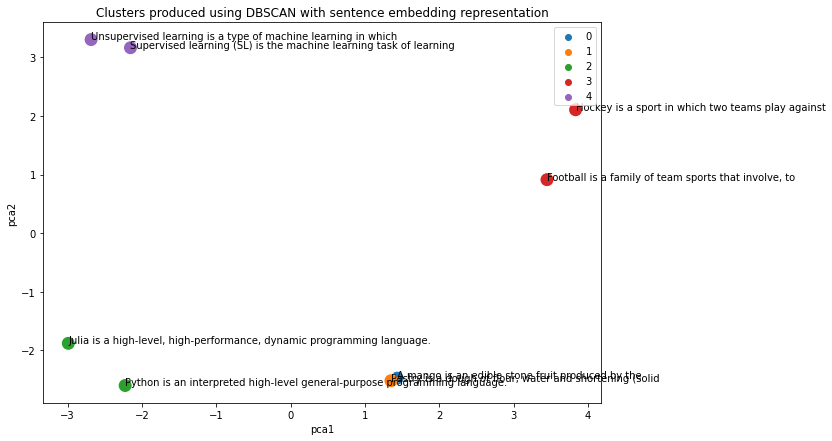

In [15]:
plot_pca_clusters(
    emb_sents,
    dbscan_labels,
    wiki_df["text"],
    True,
    200,
    'Clusters produced using DBSCAN with sentence embedding representation'
) 

<br><br><br><br>

## Exercise 2: Movie recommendations
<hr>

Let's build simple movie recommendation systems using the [MovieLens dataset](https://www.kaggle.com/prajitdatta/movielens-100k-dataset/data). The original source of the data is [here](https://grouplens.org/datasets/movielens/), and the structure of the data is described in the [README](http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html) that comes with it. The code below reads the data as a CSV assuming that it's under `data/ml-100k/` directory under your lab folder. 

In [16]:
r_cols = ["user_id", "movie_id", "rating", "timestamp"]
ratings = pd.read_csv(
    os.path.join("data", "ml-100k", "u.data"),
    sep="\t",
    names=r_cols,
    encoding="latin-1",
)
ratings.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [17]:
# We'll be using these keys later in the starter code
user_key = "user_id"
item_key = "movie_id"

### 2.1 Terminology
rubric={points:3}

Here is some notation we will be using in this homework. 

**Constants**:

 - $N$: the number of users, indexed by $n$
 - $M$: the number of movies, indexed by $m$
 - $\mathcal{R}$: the set of indices $(n,m)$ where we have ratings in the utility matrix $Y$
    - Thus $|\mathcal{R}|$ is the total number of ratings
 
**The data**:

 - $Y$: the utility matrix containing ratings, with a lot of missing entries
 - `train_mat` and `valid_mat`: Utility matrices for train and validation sets, respectively
 
    
**Your tasks:**    

1. What are the values of $N$ and $M$ in movie ratings data?  
2. What would be the shape of the dense utility matrix $Y$? 
3. What would be the fraction of non missing ratings in the utility matrix $Y$? 

In [18]:
N = len(np.unique(ratings[user_key]))
M = len(np.unique(ratings[item_key]))
print("Number of users (N):", N)
print("Number of items (M):", M)

Number of users (N): 943
Number of items (M): 1682


Shape of the dense utility matrix $Y$ would be $(N, M) = (943, 1682)$.

In [19]:
print("Fraction non-missing ratings:", len(ratings) / (N * M))

Fraction non-missing ratings: 0.06304669364224531


<br><br>

### 2.2 Splitting the data
rubric={points:5}

**Your tasks:**

1. Split the ratings data with `test_size=0.2` and `random_state=42`. 

In [20]:
# code inspired from Lecture 15
X = ratings.copy()
y = ratings[user_key]
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_valid.shape

((80000, 4), (20000, 4))

<br><br>

### 2.3 Utility matrix 
rubric={points:10}

**Your tasks**
1. Create utility matrices for train and validation sets (similar to how we did in the class). 
2. Briefly explain the difference between the train and validation utility matrices. 

> You may use the code from lecture notes with appropriate attributions.  

> You won't do it in real life but since our dataset is not that big, create a dense utility matrix in this assignment. You are welcome to try sparse matrix but then you may have to change some started code provided in the later exercises.  

In [21]:
user_mapper = dict(zip(np.unique(ratings[user_key]), list(range(N))))
item_mapper = dict(zip(np.unique(ratings[item_key]), list(range(M))))
user_inverse_mapper = dict(zip(list(range(N)), np.unique(ratings[user_key])))
item_inverse_mapper = dict(zip(list(range(M)), np.unique(ratings[item_key])))

In [22]:
# code from Lecture 15
def create_Y_from_ratings(data, N, M):
    Y = np.zeros((N, M))
    Y.fill(np.nan)
    for index, val in data.iterrows():
        n = user_mapper[val[user_key]]
        m = item_mapper[val[item_key]]
        Y[n, m] = val["rating"]

    return Y

In [23]:
# code from Lecture 15
train_mat = create_Y_from_ratings(X_train, N, M)
valid_mat = create_Y_from_ratings(X_valid, N, M)

train_mat.shape, valid_mat.shape

((943, 1682), (943, 1682))

The `train_mat` matrix only has ratings from the training set while `valid_mat` only has rating from the validation set. Both `train_mat` and `valid_mat` are of dimensions $(N, M) = (943, 1682)$ but `train_mat` only has ratings from `X_train` and `valid_mat` only has ratings from `X_valid`.

<br><br>

### 2.4 Evaluation and baseline
rubric={points:4}

To compare different models you build in this homework, let's write a couple of functions for evaluation. 
- The `error` function returns RMSE.
- The `evaluate` function prints the train and validation RMSEs. 

**Your task:**

1. Briefly explain what exactly we are comparing to evaluate recommender systems. 
2. Implement the global average baseline, where you predict everything as the global average rating. What's the RMSE of the global average baseline?

In [24]:
def error(Y1, Y2):
    """
    Returns the root mean squared error (RMSE).
    """
    return np.sqrt(np.nanmean((Y1 - Y2) ** 2))


def evaluate(pred_Y, train_mat, valid_mat, model_name="Global average"):
    print("%s train RMSE: %0.2f" % (model_name, error(pred_Y, train_mat)))
    print("%s valid RMSE: %0.2f" % (model_name, error(pred_Y, valid_mat)))

To evaluate recommender systems, we are comparing the RMSE between actual ratings and predicted ratings. This can also be done with MSE or other metrics.

In [25]:
# code form Lecture 15

# in baseline, we predict everything as the global average rating
avg = np.nanmean(train_mat)
pred_g = np.zeros(train_mat.shape) + avg
pd.DataFrame(pred_g).head()

,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,...,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262
1,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,...,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262
2,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,...,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262
3,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,...,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262
4,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,...,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262


In [26]:
evaluate(pred_g, train_mat, valid_mat)

Global average train RMSE: 1.13
Global average valid RMSE: 1.12


<br><br>

### (Optional) 2.5 $k$-nearest neighbours imputation
rubric={points:1}

**Your tasks:**

Try [KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html) to fill in the missing entries. Discuss your observations. 

<br><br>

### 2.6 Use collaborative filtering with the `surprise` package
rubric={points:6}

Use the [`surprise`](https://surprise.readthedocs.io/en/stable/) package which has implementation of SVD algorithm for collaborative filtering. You can install it as follows in your conda environment. 

```
>> conda activate cpsc330
>> conda install -c conda-forge scikit-surprise
or 
>> pip install scikit-surprise
```

**Your tasks:**

1. Carry out cross-validation using SVD algorithm in the package, similar to how we did it in the lecture on Jester dataset. Report mean RMSE and compare it with global baseline. 

In [27]:
import surprise
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import cross_validate

# load dataset
reader = Reader()
ratings_new = ratings.drop(columns=["timestamp"])
data = Dataset.load_from_df(ratings_new, reader)

# initialize SVD
k = 10
svd = SVD(n_factors=k, random_state=42)

# run cross-validation
cv_scores = cross_validate(svd, data, measures=["RMSE", "MAE"], cv=5, verbose=True)
pd.DataFrame(cv_scores).mean()

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9394  0.9313  0.9375  0.9490  0.9369  0.9388  0.0057  
MAE (testset)     0.7398  0.7375  0.7390  0.7501  0.7408  0.7415  0.0045  
Fit time          2.12    1.98    2.13    1.86    2.13    2.05    0.11    
Test time         0.14    0.14    0.31    0.14    0.15    0.18    0.07    


test_rmse    0.938828
test_mae     0.741461
fit_time     2.046123
test_time    0.176577
dtype: float64

The mean validation RMSE of SVD is marginally smaller than the validation RMSE of the global baseline model. The mean validation RMSE of SVD can be found above.

<br><br><br><br>

## Exercise 3: Short answer questions
<hr>

rubric={points:5}

Answer the following short-answer questions: 

1. What's the main difference between unsupervised and supervised learning?
2. When choosing $k$ in K-Means, why not just choose the $k$ that leads to the smallest inertia (sum of squared distances within clusters)?
3. You decide to use clustering for _outlier detection_; that is, to detect instances that are very atypical compared to all the rest. How might you do this with $k$-means?
4. You decide to use clustering for _outlier detection_; that is, to detect instances that are very atypical compared to all the rest. How might you do this with DBSCAN?
5. How might you apply clustering to recommendation systems? 

1. In unsupervised learning, the input dataset does not have target labels whereas, in supervised learning, the input dataset includes target labels. In supervised learning, we're given the target for each example in a training set, and our job is to find the mapping function that would allow us to predict the outcome of new examples. In unsupervised learning, our job is to find the patterns in unlabeled data.

2. One cannot choose the $k$ that leads to the smallest inertia b/c inertia decreases as $k$ increases and if we choose $k = \text{number of examples}$ then each example will have its own cluster and the intra-cluster distance will be 0 and thus, running K-Means would be pointless.

3. To perform outlier detection with K-Means, one could retrieve the computed distances of each data point from its corresponding cluster center and select a thresholded list of points with the largest distances as "outliers".

4. We can decrease `eps` to be more strict about what it means for a point to be close. This can allow outliers to stand out as noise points. However, assuming that we have the correct hyperparameters to detect outliers, DBSCAN is inherently able to perform outlier detection. If we use sklearn's DBSCAN, the outliers are assigned the label of `-1` when the model is fit. 

5. When applying clustering or unsupervised learning to recommendation systems, this is known as collaborative filtering. The approach uses the user-item interactions provided in the ratings matrix to determine similarities between users and items which helps predict missing entries. This is based on the idea that if a user has a similar rating as another user, then the other user is more likely to have ratings for other things that are also similar to that of the first user. Thus, a clustering algorithm can help cluster users together so that the model can determine which users are similar.


<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 